# Convolutional Neural Networks in tensorflow and keras

### Objective:

We want to implement a Convolutional Neural Network (CNN) to do image recognition. For this we will use the well-known CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

We will first code the simple ConvNet described below using 
- tensorflow https://www.tensorflow.org

then do the same using
- keras : https://keras.io


The input of the CNN is a set of (32,32,3) image tensors. We apply :

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)

# Load packages

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Import data

We first import CIFAR-10 dataset.

In [0]:
from keras.utils.np_utils import to_categorical

from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train))

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
[0 1 2 3 4 5 6 7 8 9]


The CIFAR-10 dataset has 10 classes. These are the following :

In [0]:
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

### Display some of the images

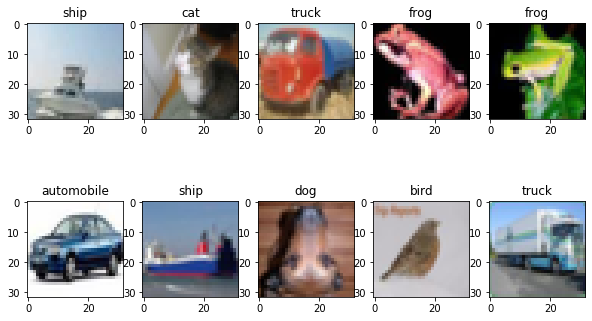

In [0]:
plt.figure(figsize=(10, 6))
for idx,i in enumerate(range(100,110)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(X_train[i, :, :, :])
    plt.title(cifar_10_list[int(y_train[i])])

In [0]:
y_train.shape

(50000, 1)

## Format conversion

We now convert the format of the data. In the case of CNNs, and contrary to MLPs, the inputs are not simply vectors of arbitrary size. For example, in the case of images, it is important to distinguish the different dimensions (otherwise the network would not know how to carry out convolutions). Therefore, we need to carry out the following operation :

- reshape the input ```X_train```and ```X_test``` to a set of matrices of size (32,32) and depth 3 (for the 3 R,G,B colors), convert the data to float32 and normalize them in the range [0,1]. The final dimensions of the image data should be : [batch_size, height, width, n_channels]

Furthermore, we must also convert the label vectors to matrices with k columns, where k is the number of classes. This allows us to carry out the cross-entropy for multi-class problems. Therefore :

- convert the output label ```y_train``` and ```y_test``` to one-hot encoding format.

In [0]:
# input image dimensions
img_rows, img_cols, nb_channels = 32, 32, 3
nb_classes = 10

# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('Y_train shape:', Y_train.shape)
print('There is {} train data'.format(X_train.shape[0]))
print('There is {} test data'.format(X_test.shape[0]))
print(img_rows, img_cols, nb_channels)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
Y_train shape: (50000, 10)
There is 50000 train data
There is 10000 test data
32 32 3


For memory and speed reasons, we are going to reduce the amount of training data :

In [0]:
n_train_samples = 10000
X_train = X_train[0:n_train_samples,:,:,:]
Y_train = Y_train[0:n_train_samples,:]
print(X_train.shape)
print(Y_train.shape)

(10000, 32, 32, 3)
(10000, 10)


# 1. CNN with tensorflow

We are now going to create a CNN with Tensorflow, and train it on the previously loaded CIFAR dataset.
- First define the input and output using ```tf.placeholder```
- Define the weights and biases of the CNN using ```tf.variable``` or ```tf.get_variable```
    - We can initialize them using ```tf.contrib.layers.xavier_initializer```(see https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer)
- Perform the convolution using ```tf.nn.conv2d``` 
- Apply the activation function using ```tf.nn.relu```
- Perform the max pooling using ```tf.nn.max_pool```
- Flatten the output of the convolution using ```tf.contrib.layers.flatten```
- Perform the Fully-Connected part using ```tf.contrib.layers.fully_connected```

Also, note that in Tensorflow, we can carry out the softmax + cross entropy all in one step with the following function :

- ```tf.nn.softmax_cross_entropy_with_logits()```

This has the advantage of being optimised and stabilised by the programmers who wrote Tensorflow, so that we do not have numerical problems.

$\textbf{IMPORTANT NOTE}$ : Please note that this part in Tensorflow is just so that we have had some experience with CNNs in Tensorflow. So do not spend a lot of time trying to get great accuracy results. If we want to do this, do it in the Keras part.

In [0]:
import tensorflow as tf

learning_rate = 0.01
n_epochs = 20
batch_size = 64

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)


# --- Size of the successice layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters

In [ ]:
tf.reset_default_graph()

# input tensor are of shape [batch, in_height, in_width, in_channels]  
# filter / kernel tensor are of shape [filter_height, filter_width, in_channels, out_channels]

x = tf.placeholder("float", [None, img_rows, img_cols, nb_channels])
y = tf.placeholder("float", [None,nb_classes])

W1 = tf.get_variable(
    "W1",
    shape=[kernel_size[0], kernel_size[1], n_h_0, n_h_1],
    initializer = tf.contrib.layers.xavier_initializer(seed = 0)
)

W2 = tf.get_variable(
    "W2",
    shape=[kernel_size[0], kernel_size[1], n_h_1, n_h_2],
    initializer = tf.contrib.layers.xavier_initializer(seed = 0)
)

W3 = tf.get_variable(
    "W3",
    shape=[kernel_size[0], kernel_size[1], n_h_2, n_h_3],
    initializer = tf.contrib.layers.xavier_initializer(seed = 0)
)

b1 = tf.get_variable("b1", [n_h_1], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
b2 = tf.get_variable("b2", [n_h_2], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
b3 = tf.get_variable("b3", [n_h_3], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

#perform the 1rst convolution : 
Z1 = tf.nn.conv2d(x, W1, strides = [1,1,1,1], padding = 'VALID')
#ReLu activation
A1 = tf.nn.relu(Z1+b1)

#perform the 2nd convolution : 
Z2 = tf.nn.conv2d(A1, W2, strides = [1,1,1,1], padding = 'VALID')
#Relu
A2 = tf.nn.relu(Z2+b2)
#MaxPool
P2 = tf.nn.max_pool(A2, ksize = [1, pool_size[0], pool_size[0], 1], strides = [1, pool_size[0], pool_size[0], 1], padding = 'VALID')

#Convolution
Z3 = tf.nn.conv2d(P2, W3, strides = [1,1,1,1], padding = 'VALID')
#ReLu
A3 = tf.nn.relu(Z3+b3)
#Max_Pool
P3 = tf.nn.max_pool(A3, ksize = [1, pool_size[0], pool_size[0], 1], strides = [1, pool_size[0], pool_size[0], 1], padding = 'VALID')
#Flatten the output
P3 = tf.contrib.layers.flatten(P3)
#Fully Connected
Z4 = tf.contrib.layers.fully_connected(inputs=P3, num_outputs=nb_classes, activation_fn=None)
# --- END CODE HERE

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z4, labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

## Train the model

Cost after epoch 0: 2.098981
Cost after epoch 1: 1.710150
Cost after epoch 2: 1.583832
Cost after epoch 3: 1.498030
Cost after epoch 4: 1.434169
Cost after epoch 5: 1.384612
Cost after epoch 6: 1.339196
Cost after epoch 7: 1.299171
Cost after epoch 8: 1.265729
Cost after epoch 9: 1.237213
Cost after epoch 10: 1.230309
Cost after epoch 11: 1.221071
Cost after epoch 12: 1.203070
Cost after epoch 13: 1.184295
Cost after epoch 14: 1.148110
Cost after epoch 15: 1.162576
Cost after epoch 16: 1.167101
Cost after epoch 17: 1.185709
Cost after epoch 18: 1.165549
Cost after epoch 19: 1.119857


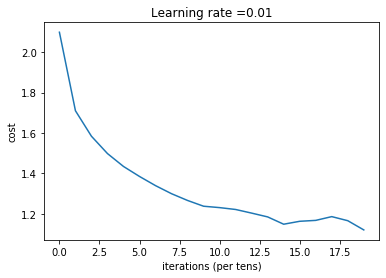

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.6175
Test Accuracy: 0.4958


In [0]:
init = tf.global_variables_initializer()
n_batches = int(np.ceil(X_train.shape[0] / float(batch_size)))
costs = []
X_input, Y_output = x, y


with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        minibatch_cost = 0.
        for batch_idx in range(n_batches):
            # BEGIN CODE HERE
            start = batch_idx * batch_size
            stop = start + batch_size
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={x: X_train[start: stop,:,:,:], y: Y_train[start: stop,:]})
            # END CODE HERE
            minibatch_cost += temp_cost / n_batches

        if epoch % 1 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            
        costs.append(minibatch_cost) 
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Calculate the correct predictions
    predict_op = tf.argmax(Z4, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y_output, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    train_accuracy = accuracy.eval({X_input: X_train, Y_output: Y_train})
    test_accuracy = accuracy.eval({X_input: X_test, Y_output: Y_test})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    


# 2. CNN with keras

We are now going to create the same network with Keras. As we shall see, the interface is quite simplified in comparison to Tensorflow.

## We first import keras packages

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
print(keras.__version__)

2.2.5


## We define the parameters of the model, and of the training

In [0]:
input_shape = (img_rows, img_cols, nb_channels)

## Creating the CNN model in Keras using the Sequential API

Keras has a simple way of adding layers to create a neural network. First, we can indicate to Keras that the model is 'sequential', that is to say, a straight-forward CNN. For this, we can use the following function :
- ```model = Sequential()```

After this, we can add layers with the function.

- ```model.add()```

We can then use the ```Conv2D```, ```Activation```, ```MaxPooling2D```, ```Flatten``` and ```Dense``` (fully connected) functions to specify different layer types. Note that in the case of this approach, we will have to specify the input image size in the first layer of the network. So, for example, if the first layer is convolutional :

- model = Sequential()
- model.add(Conv2D(nb_filters, kernel_size, input_shape=input_shape, name='Conv1'))


## Creating the CNN model in Keras using the standard API

Otherwise, another approach to creating the model is to explicitly create the input variable, and just cascade the different functions, as in Tensorflow. So, for the same example, we would have :

- input = Input(shape=(img_rows,img_cols,nb_channels))
- output = Conv2D(input_shape=self.img_shape,filters=nb_filters,kernel_size=kernel_size)(input)
- model = Model(input, output)

In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size, input_shape=input_shape, padding ='valid'))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, kernel_size, input_shape=input_shape, padding ='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(nb_filters, kernel_size, input_shape=input_shape, padding ='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten(name='Flatten'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
# --- END CODE HERE

## Compile the model

We define here the ```loss``` that we will minimize and the ```optimizer``` (the specific algorithm used to perform gradient descent).

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

## We display a summary of the model created (but not yet trained)

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 12, 12, 32)       

## Perform the training

In [0]:
model.fit(X_train, Y_train,
          batch_size=batch_size, 
          nb_epoch=n_epochs,
          verbose=1, 
          validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """



Train on 10000 samples, validate on 10000 samples
Epoch 1/20





10000/10000 [==============================] - 3s 287us/step - loss: 2.1435 - acc: 0.2213 - val_loss: 2.0944 - val_acc: 0.2462
Epoch 2/20
10000/10000 [==============================] - 2s 244us/step - loss: 2.0331 - acc: 0.2638 - val_loss: 2.0215 - val_acc: 0.2633
Epoch 3/20
10000/10000 [==============================] - 2s 246us/step - loss: 1.9616 - acc: 0.2917 - val_loss: 1.8760 - val_acc: 0.3223
Epoch 4/20
10000/10000 [==============================] - 2s 250us/step - loss: 1.8517 - acc: 0.3296 - val_loss: 1.8433 - val_acc: 0.3345
Epoch 5/20
10000/10000 [==============================] - 3s 250us/step - loss: 1.7750 - acc: 0.3640 - val_loss: 1.7506 - val_acc: 0.3686
Epoch 6/20
10000/10000 [==============================] - 2s 250us/step - loss: 1.7304 - acc: 0.3872 - val_loss: 1.7181 - val_acc: 0.3787
Epoch 7/20
10000/10000 [==============================] - 2s 248us/step - loss: 1.6868 - acc: 0.4033 - val_loss: 1.6

## We evaluate the performances of the model on the test data

In [0]:
score = model.evaluate(X_test, Y_test, verbose=False)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.6101440740585327
Test accuracy: 0.4149


Let's take a look at what the network has learned.

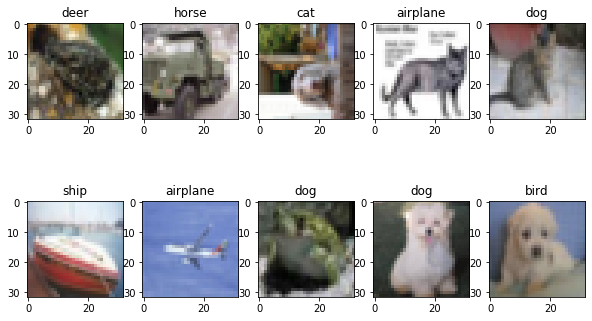

In [0]:
plt.figure(figsize=(10, 6))
for idx,i in enumerate(range(100,110)):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    predicted_class = np.argmax(np.squeeze(model.predict(np.expand_dims(X_test[rand_ind,:,:,:],axis=0))))
    plt.imshow(X_test[rand_ind,:,:,:])
    plt.title(cifar_10_list[int(predicted_class)])

## Now, display all (32) trained filters of the first layer

We can explore the network parameters easily with Keras. For example ```model.layers``` is a list of the layers of the network. Each element of the network contains the information necessary for this layer. To show the content of a layer i, type :

```dir(model.layers[i])```

Display all (32) trained filters of the first layer :

32
(3, 3)
(3, 3, 3, 32)


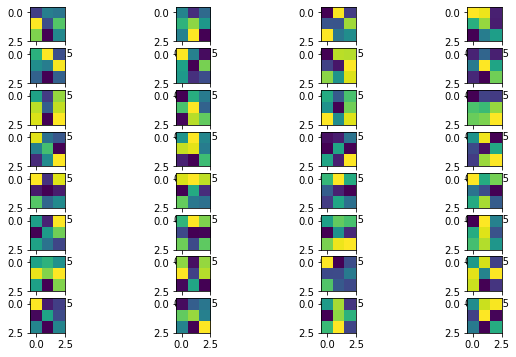

In [0]:
print(model.layers[0].filters)
print(model.layers[0].kernel_size)
print(model.layers[0].get_weights()[0].shape)
plt.figure(figsize=(10, 6))
for num in range(0,32):
    plt.subplot(8, 4, num+1)
    plt.imshow(model.layers[0].get_weights()[0][:,:,0,num])